In [0]:
import imageio
import cv2
import numpy as np
import os
import pickle
import re
import PIL
from PIL import Image

## Challenge Categories

In [0]:
CATEGORIES = [
    "boxing",
    "handclapping",
    "handwaving",
    "jogging",
    "running",
    "walking"
]

IMG_W = 60
IMG_H = 80
CHANNELS = 1
INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NCLASSES = 6

EPOCHS = 25
BATCH_SIZE = 64

### Spliting Dataset

In [0]:
# Dataset are divided according to the instruction at:
# http://www.nada.kth.se/cvap/actions/00sequences.txt
TRAIN_PEOPLE_ID = [11, 12, 13, 14, 15, 16, 17, 18]
DEV_PEOPLE_ID = [19, 20, 21, 23, 24, 25, 1, 4]
TEST_PEOPLE_ID = [22, 2, 3, 5, 6, 7, 8, 9, 10]

## Loading Dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
print("Loading dataset ..")
train_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/train.p", "rb"))
dev_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/dev.p", "rb"))
test_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/test.p", "rb"))

Loading dataset ..


##Preparing dataset

In [0]:
def read_ds(ds="train"):
  if(ds == "dev"):
    videos = dev_videos
  elif (ds == "test"):
    videos = test_videos
  else:
    videos = train_videos
      
  X = []
  y = []
  for video in videos:
      for frame in video["frames"]:
          X.append(frame.reshape(INPUT_SHAPE))
          y.append(CATEGORIES.index(video["category"]))

  X = np.array(X, dtype=np.float32)
  y = np.array(y, dtype=np.uint8)

  '''
  mean = np.mean(X)
  X -= float(mean)
  '''
  return X, y

In [0]:
X_train, y_train = read_ds(ds="train")
X_dev, y_dev = read_ds(ds="dev")
X_test, y_test = read_ds(ds="test")

In [0]:
X_train[0].shape

(60, 80, 1)

In [0]:
X_train.shape

(74672, 60, 80, 1)

In [0]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Input, ZeroPadding2D, Conv2D, MaxPooling2D, Activation, add
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow.keras
from tensorflow.keras.layers import Conv2D, Dropout, MaxPool2D, AvgPool2D, Add, Dense 
from tensorflow.keras.preprocessing.image import load_img, img_to_array


from keras.models import Model

from keras.utils import plot_model

import warnings
#warnings.warn("ignore")
import os

Using TensorFlow backend.


In [0]:
from keras.applications import ResNet50
from keras import Model, layers

In [0]:
X_train2 = X_train
X_dev2 = X_dev
X_test2 = X_test

In [0]:
X_train2 = np.repeat(X_train2[...,], 3, 3)
X_dev2 = np.repeat(X_dev2[...,], 3, 3)
X_test2 = np.repeat(X_test2[...,], 3, 3)

In [0]:
X_train2.shape

(74672, 60, 80, 3)

In [0]:
inputs = Input((IMG_W, IMG_H, 3))
conv_base = ResNet50(
    include_top=False,
    input_tensor=inputs,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False
    
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(NCLASSES, activation='softmax')(x)
model = Model(conv_base.input, predictions) 

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step



In [0]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
import tensorflow as tf

from keras.layers.merge import concatenate

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60, 80, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 66, 86, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 30, 40, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 30, 40, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

In [0]:
X_train2.shape

(74672, 60, 80, 3)

In [0]:
trained_model = model.fit(X_train2, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data=(X_dev2, y_dev) , shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 74672 samples, validate on 72821 samples
Epoch 1/25
74672/74672 [==============================] - 183s 2ms/step - loss: 0.5724 - acc: 0.7751 - val_loss: 3.2855 - val_acc: 0.3056
Epoch 2/25
74672/74672 [==============================] - 176s 2ms/step - loss: 0.3494 - acc: 0.8612 - val_loss: 4.5668 - val_acc: 0.2841
Epoch 3/25
74672/74672 [==============================] - 177s 2ms/step - loss: 0.2817 - acc: 0.8896 - val_loss: 4.1100 - val_acc: 0.3241
Epoch 4/25
74672/74672 [==============================] - 176s 2ms/step - loss: 0.2385 - acc: 0.9078 - val_loss: 4.5359 - val_acc: 0.3045
Epoch 5/25
74672/74672 [==============================] - 176s 2ms/step - loss: 0.2066 - acc: 0.9199 - val_loss: 5.8310 - val_acc: 0.2972
Epoch 6/25
74672/74672 [==============================] - 176s 2ms/step - loss: 0.1853 - acc: 0.9298 - val_loss: 5.0688 - val_acc: 0.2879
Epoch 7/25
74672/74672 [==

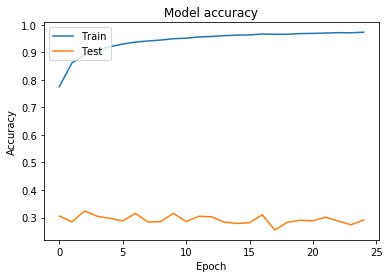

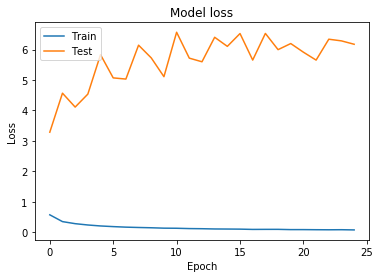

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model.evaluate(X_test2, y_test)

79266/79266 [==============================] - 138s 2ms/step


[6.73077379219381, 0.2671511114475311]

In [0]:
model.save_weights('Resnet50_KTH.h5')

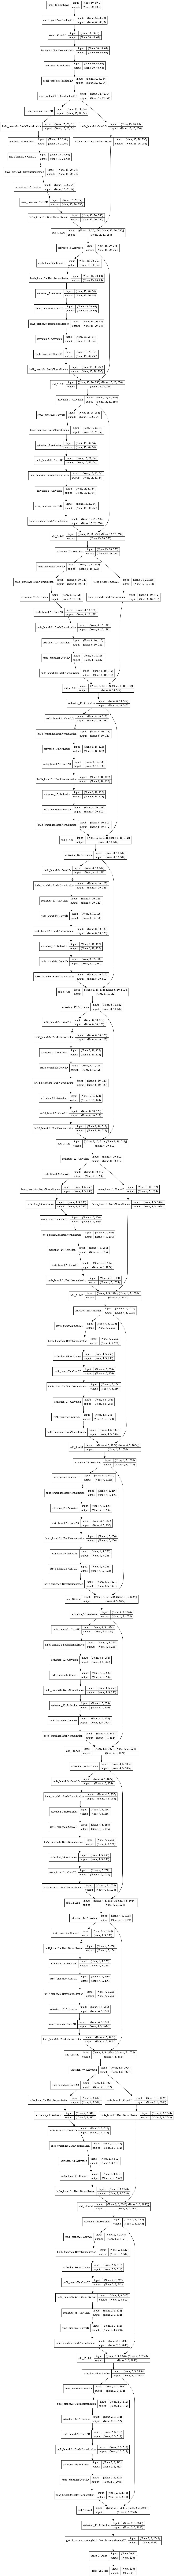

In [0]:
plot_model(model, show_shapes=True, to_file='Resnet50.png')